In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
%matplotlib inline

In [2]:
# Choosing a "random" random seed (smashing keboard) to get the same set of paths
random_seed = 8946594
rs = np.random.RandomState(np.random.MT19937(random_seed))

# Generate a set of nodes $V$, with $|V|=977$, and random shipping distances between them

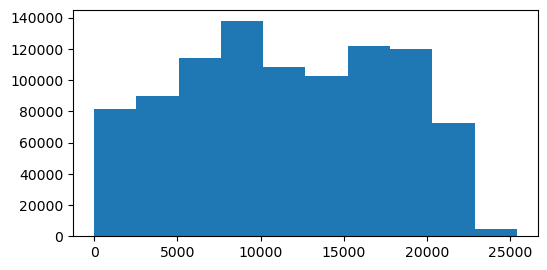

In [3]:
# Get the distance distribution
real_distances = dict()
dist_distribution = []
with open("../data/port_shipping_distances.csv", 'r') as fin:
    for line in fin:
        u, v, dist = line.strip().split(',')
        dist = float(dist)
        real_distances[(u,v)] = dist
        dist_distribution.append(dist)
        
dist_distribution = np.array(dist_distribution)
min_distance = dist_distribution.min()
max_distance = dist_distribution.max()
# Plot the distribution
fig, axs = plt.subplots(1, 1, dpi=100, figsize=(6, 3), squeeze=False)
axs[0][0].hist(dist_distribution)
plt.subplots_adjust(wspace=0.35)

In [4]:
# Since it looks roughly like a 2-mode normal, we'll fit a gaussian mxiture
gm = GaussianMixture(n_components=2, random_state=rs).fit(dist_distribution.reshape((-1, 1)))

# Print the paramters of the estimated distance distribution
n = dist_distribution.shape[0]
print(f'mu1={gm.means_[0]}, mu2={gm.means_[1]}')
print(f'sigma1={np.sqrt(gm.covariances_[0])}, sigma2={np.sqrt(gm.covariances_[1])}')
print(f'w1={gm.weights_[0]}, w2={gm.weights_[1]}')
print(f'n1={int(n * gm.weights_[0])} n2={int(n * gm.weights_[1])}')

mu1=[6781.71331838], mu2=[17010.92539441]
sigma1=[[3606.02540042]], sigma2=[[3219.42075219]]
w1=0.5319082577933362, w2=0.4680917422066712
n1=507202 n2=446349


977


(array([ 46440., 102954., 142002., 126744.,  96982., 112994., 142598.,
        115776.,  53408.,  13654.]),
 array([2.02138170e+00, 2.54116860e+03, 5.08031582e+03, 7.61946304e+03,
        1.01586103e+04, 1.26977575e+04, 1.52369047e+04, 1.77760519e+04,
        2.03151991e+04, 2.28543464e+04, 2.53934936e+04]),
 <BarContainer object of 10 artists>)

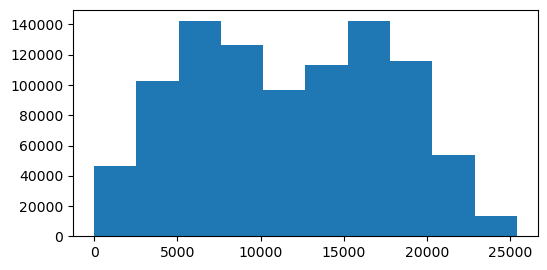

In [5]:
# Assign each pair of nodes a distance
V = list(range(0, 977))
print(len(V))
estimated_distances = dict()
estimated_distances_dist = []
for s in V:
    for t in V:
        if s in estimated_distances and t in estimated_distances[s] or s == t:
            # For simplicity, we will say distances are symmetric
            # and the distance between a port and itself will be undefined,
            # since we disallow self-loops
            continue
        
        sample = gm.sample()[0][0][0]
        # Need to truncate to a reasonable minimum distance value
        while sample < min_distance or sample > max_distance:
            sample = gm.sample()[0][0][0]
        estimated_distances.setdefault(s, dict())
        estimated_distances[s][t] = sample
        estimated_distances.setdefault(t, dict())
        estimated_distances[t][s] = sample
        
        # Add to the distribution twice
        estimated_distances_dist.append(sample)
        estimated_distances_dist.append(sample)

estimated_distances_dist = np.array(estimated_distances_dist)
fig, axs = plt.subplots(1, 1, dpi=100, figsize=(6, 3), squeeze=False)
axs[0][0].hist(estimated_distances_dist)

# Given the pairwise distance between nodes in $V$, generate random data

In [6]:
import sys
sys.path.append("../code/")
from create_edgelist import remove_selfloops

In [7]:
# Get the real data so that we can try to emulate it
walks = []
with open("../data/all_routes_2015.ngram", 'r') as fin:
    for line in fin:
        walk = remove_selfloops(line.strip().split(','))
        walks.append(walk)

In [8]:
# Count the number of repeated paths
walks_set = set()
repeated_by_length = dict()
for walk in walks:
    if tuple(walk) in walks_set:
        repeated_by_length.setdefault(len(walk), 0)
        repeated_by_length[len(walk)] += 1
    walks_set.add(tuple(walk))
num_repeated_paths = len(walks)-len(walks_set)
print(num_repeated_paths)
print(repeated_by_length)

74
{10: 2, 3: 48, 2: 1, 4: 14, 5: 5, 6: 2, 9: 1, 16: 1}


In [9]:
def get_current_dists(current_node, estimated_distances):
    # The nodes with the largest distances should be the least probable
    current_node_dists = 1.0 / np.array([estimated_distances[current_node][v] for v in estimated_distances[current_node]]).reshape((976,))
    current_node_dists = current_node_dists / current_node_dists.sum()
    return current_node_dists

def compute_walk(closed_walk, walk_length, total_distance, estimated_distances,
                 num_nodes_to_try=20, distance_margins = [0.0, 0.01]):
    # We'll try to get distances within 5%, then 10%, then 15%, then 20%
    # If we can't find a path for any of those distances, we will choose a new start node
    # If we fail with 10 start nodes, for now we'll fail the whole walk
    
    # Get a list of all of the nodes
    all_nodes = list(range(977))
    # We will loop until a walk is found, up to num_nodes_to_try*len(distance_margins)
    for nodes_tried in range(num_nodes_to_try):
        # Note: This does not preserve inequality in start/end node appearances
        start_node = rs.choice(all_nodes, )
        
        # Loop over the distance margins looking for an acceptable walk
        for current_margin in distance_margins:
            max_distance = total_distance + total_distance*current_margin
            #min_distance = total_distance - total_distance*current_margin
            
            current_dist = 0.0
            # Initiate the walk and set current_node to start_node
            walk = [start_node]
            current_node = start_node
            
            # Compute the distance between current_node and all other nodes
            current_node_dists = get_current_dists(current_node, estimated_distances)
            
            # Try to construct a walk
            for step in range(walk_length):
                # Deal with the last step of a closed walk
                if len(walk) == walk_length-1 and closed_walk:
                    candidate_node = start_node
                    if current_node == candidate_node:
                        # This would cause a self-loop
                        break
                        
                    # Check that the closed walk works within the margin
                    candidate_dist = estimated_distances[current_node][candidate_node]
                    if (current_dist + candidate_dist) <= max_distance:
                        walk.append(candidate_node)
                        return walk
                    else:
                        # Failure
                        break
                else:
                    # Choose a random node, biased towards closer nodes
                    all_other_nodes = list(set(all_nodes)-set([current_node]))
                    candidate_node = rs.choice(all_other_nodes, p=current_node_dists)
                    candidate_dist = estimated_distances[current_node][candidate_node]
                    if (current_dist + candidate_dist) <= max_distance:
                        walk.append(candidate_node)
                        current_dist += candidate_dist
                        current_node = candidate_node
                        current_node_dists = get_current_dists(current_node, estimated_distances)

                    # Was this the last step?
                    if len(walk) == walk_length:
                        return walk
                    
                        
    return False

In [10]:
# For each real walk, find a "doppleganger" walk through the random network
# Match exactly: the number of steps in the walk and whether it is open or closed
# Match reasonably closely: the total distance of the walk
synthetic_walks = []
total_tries = 500
for walk in walks:
    # Note the number of nodes
    walk_length = len(walk)
    # Note whether the walk is open or closed
    closed_walk = True
    if walk[0] != walk[-1]:
        closed_walk = False
    
    # Compute the distance of the real walk
    total_distance = sum([real_distances[(walk[i-1], walk[i])] for i in range(1, len(walk))])
    
    # Get a random walk
    random_walk = compute_walk(closed_walk, walk_length, total_distance, estimated_distances)
    tries = 1
    while not random_walk:
        tries += 1
        random_walk = compute_walk(closed_walk, walk_length, total_distance, estimated_distances)
        if tries == total_tries:
            break
    if not random_walk:
        print(f"Gave up on walk: {walk} after {tries} tries.")
        continue
    synthetic_walks.append(random_walk)

# Above we computed the number of repeated walks by length.
# We'll now randomly add repeats to our synthetic set.
walks_by_length = dict()
for walk in walks:
    walks_by_length.setdefault(len(walk), [])
    walks_by_length[len(walk)].append(walk)
    
for k, num in repeated_by_length.items():
    k_length_walks = walks_by_length[k]
    # If we've already got repeats, discount for them
    num_existing_repeats = len(k_length_walks)-len(set([tuple(walk) for walk in k_length_walks]))
    if num_existing_repeats > 0:
        num = num - (num_existing_repeats)
    # Choose num repeats and add them to our list of walks
    idxs = rs.choice(list(range(len(k_length_walks))), size=num, replace=True)
    for idx in idxs:
        synthetic_walks.append(list(k_length_walks[idx]))

In [11]:
print(len(walks))

1622


In [12]:
print(len(synthetic_walks))

1622


max(total_dist_real): 77803.0, max(total_dist_synthetic): 68287.12867530764


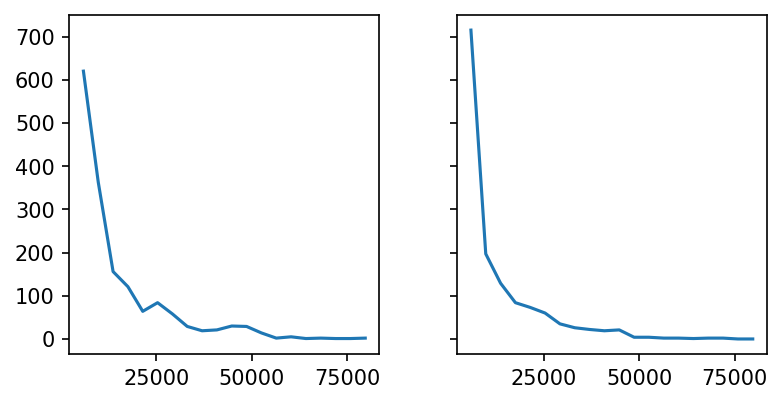

In [13]:
# Compare total distance distributions
total_dist_real = []
total_dist_synthetic = []
for i in range(len(walks)):
    real_walk = walks[i]
    total_dist_real.append(sum([real_distances[(real_walk[j-1], real_walk[j])] for j in range(1, len(real_walk))]))
    synthetic_walk = synthetic_walks[i]
    total_dist_synthetic.append(sum([estimated_distances[synthetic_walk[j-1]][synthetic_walk[j]]
                                     for j in range(1, len(synthetic_walk))]))

fig, axs = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(6, 3), squeeze=False, sharey=True)
plt.subplots_adjust(wspace=0.25)
ax = axs[0][0]
hist, bins = np.histogram(total_dist_real, bins=20)
x = bins[1:] + (bins[1:] - bins[:-1]) / 2
ax.plot(x, hist)
ax = axs[0][1]
hist, _ = np.histogram(total_dist_synthetic, bins=bins)
ax.plot(x, hist)
print(f"max(total_dist_real): {max(total_dist_real)}, max(total_dist_synthetic): {max(total_dist_synthetic)}")

In [14]:
# write paths
with open("../data/synthetic/synthetic_walks.ngram", 'w') as fout:
    for walk in synthetic_walks:
        walk_str = ','.join(map(str, walk)) + '\n'
        fout.write(walk_str)

In [15]:
# write distances
with open("../data/synthetic/synthetic_distances.csv", 'w') as fout:
    for s in estimated_distances:
        for t in estimated_distances[s]:
            fout.write(f"{s},{t},{estimated_distances[s][t]}\n")